# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Universidad Nacional de Córdoba
---

### Importación de librerías

In [1]:
import warnings
import datetime
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBClassifier

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared
from sklearn.impute import SimpleImputer

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

### Lectura del dataset 

In [2]:
df = pd.read_parquet('df_supervisado_agrupado.parquet')
df

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,000f0b73ebfa002a79a0642b82e87919904,202101.0,64.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11616.45
7406,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68
7407,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08
7408,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64


Ordenamos nuestro conjunto de datos en función a la variable anio_mes_cupon.

In [3]:
df = df.sort_values(by = ['anio_mes_cupon'], ascending = True)

In [4]:
df['monto_ajustado'].describe().round(2)

count      7410.00
mean      11808.44
std       14823.98
min      -14160.39
25%         987.78
50%        6373.59
75%       17248.53
max      134045.42
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

### Distribución de features numericas con respecto al target, monto_ajustado

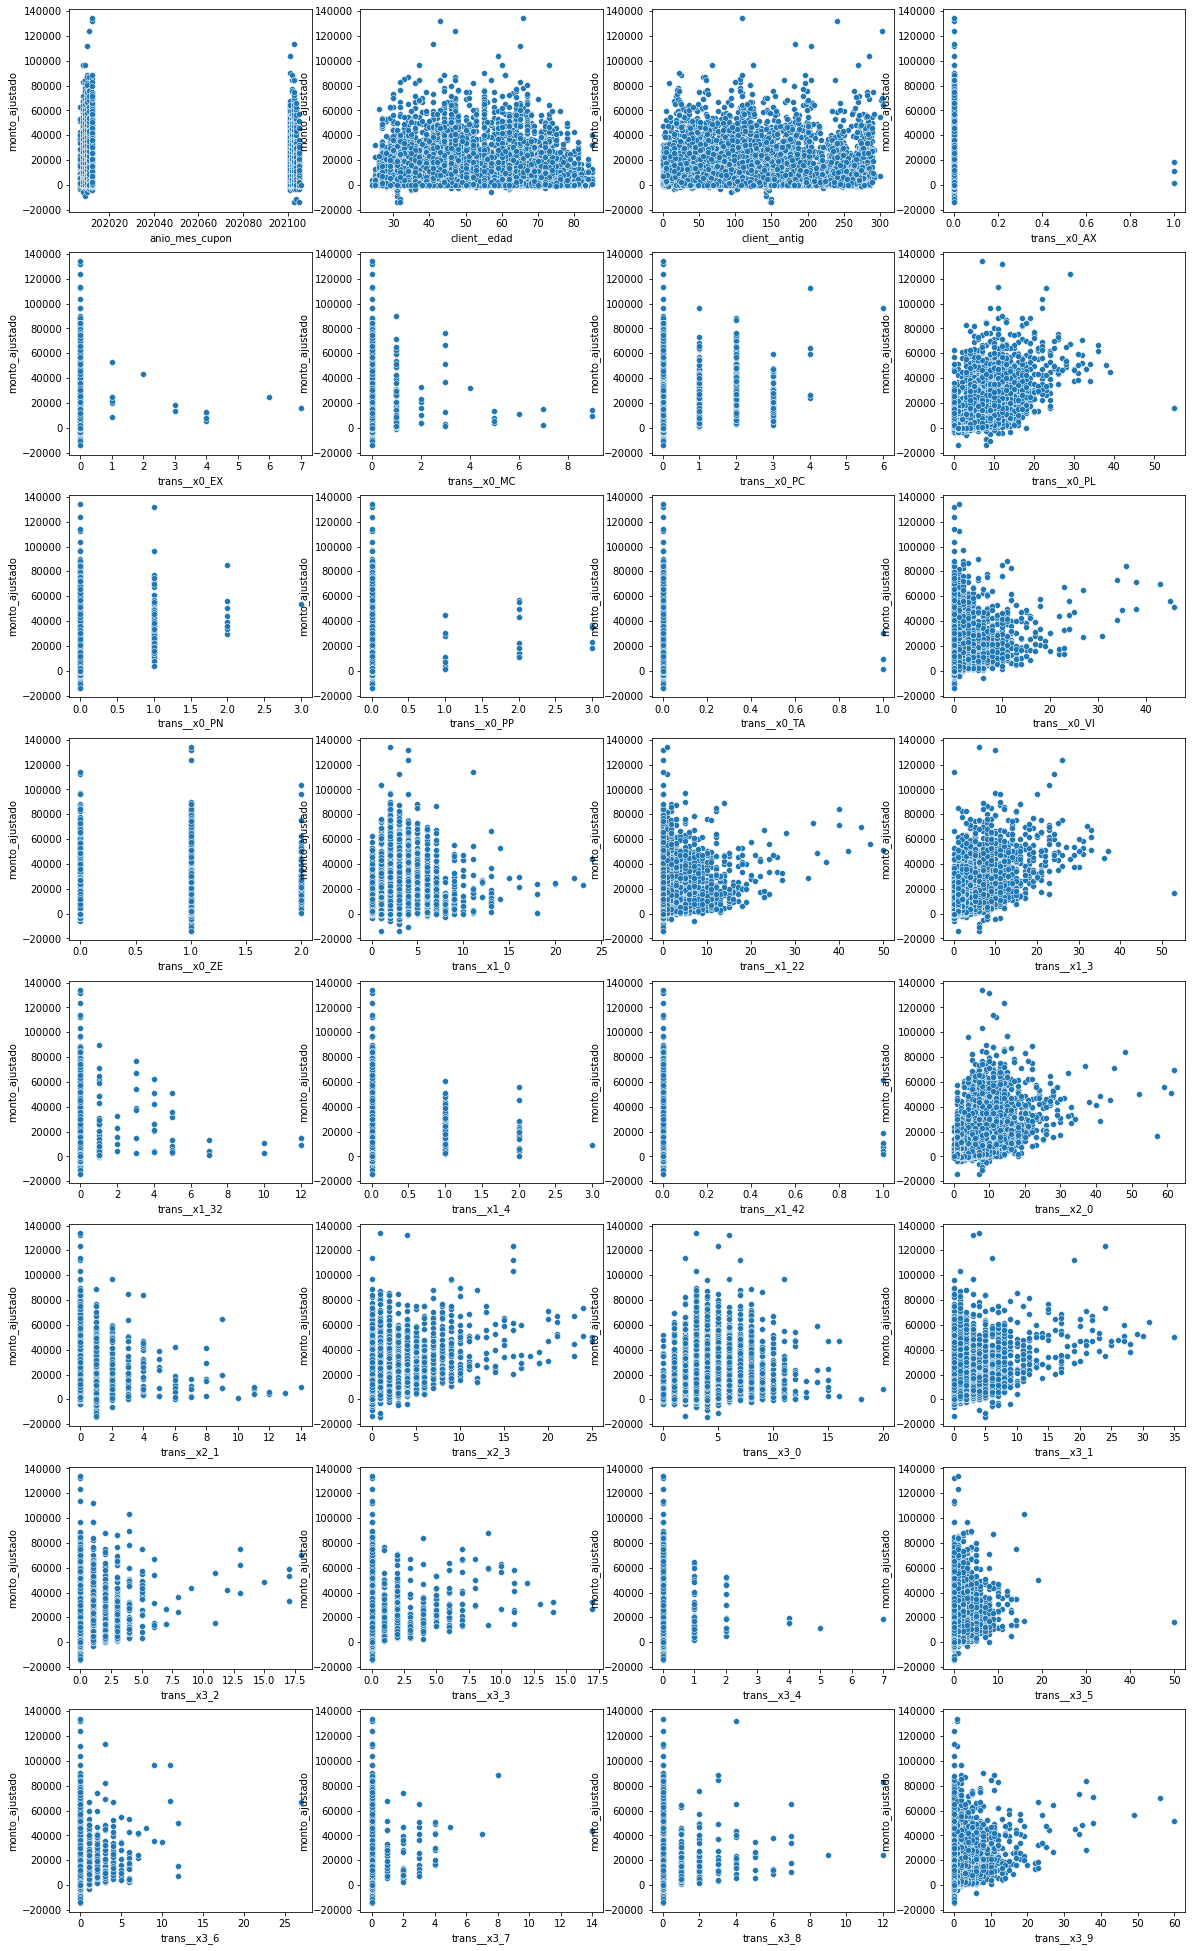

In [5]:
# Visualizamos solo las numericas y las transaccionales sumarizadas
cols = [x for x in df.columns.values if 'client__x' not in x]
cols.remove('dni_titular_movimiento')
#cols.remove('anio_mes_cupon')
cols.remove('monto_ajustado')

# plot
n_cols = 4
n_rows = math.ceil(len(cols)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 35))
count = 0
for i in cols:    
    row = math.floor(count / n_cols)
    col = count % n_cols
    ax = axs[row, col]
    sns.scatterplot(data=df, x=i, y='monto_ajustado', ax=ax)
    count =count +1

plt.show()

Analisis de distribucion de monto_ajustado con respecto a los features numericos

- **fecha_cupon_movimiento**: No hay una relacion visible. Los puntos estan distribuidos mayoritariamente en el rango entre 0 y 20000 para casi todos los meses presentes con excepcion del primer mes donde la cantidad de casos baja con respecto al resto de los meses.
- **edad_cliente**: Similar a fecha, la mayor parte de los montos se concentra entre 0 y 20000. Algo a destacar es que a medida que la edad supera los 60 años, la cantidad de transacciones baja. El grueso de transacciones estan concentradas en edades menores a 70
- **antiguedad_cliente**: A partir de la antiguedad 200, se puede observar que la cantidad de transacciones baja, lo cual podria explicarse en base a que hay menos clientes con antiguedad tan alta. Sin embargo, se puede llegar a ver una aplanacion mas paulatina de los casos que en el caso de la edad. Despues de cierta antiguedad la cantidad de transacciones baja pero se mantiene en una meseta, en cambio en el caso de la edad la baja es mas abrupta.

El scatterplot de features categoricos nos brinda unicamente informacion sobre la concentracion de casos en cada categoria, pero no podriamos con eso solo proyectar el comportamiento de las regresiones para la prediccion de los montos. 

### Balanceo de DataFrame

La cantidad de filas debería ser igual para cada mes. Cada cliente dentro del dataset debería tener al menos una transacción dentro de cada mes, y si no la tiene entonces debería tener una con todos 0 en las variables de transaccion. Con esto tendriamos un dataset balanceado. 

In [6]:
df['dni_titular_movimiento'].nunique() * df['anio_mes_cupon'].nunique() # dnis x cantidad de meses

9852

In [7]:
print('Cantidad de Meses por Titular (Final):',df['dni_titular_movimiento'].nunique() * df['anio_mes_cupon'].nunique())
print('Shape Dataframe:', df.shape)

Cantidad de Meses por Titular (Final): 9852
Shape Dataframe: (7410, 55)


Corroboramos aquellos titulares que no tienen movimientos en todos los meses

In [8]:
df[['dni_titular_movimiento','anio_mes_cupon']].drop_duplicates().groupby(['dni_titular_movimiento']).size().reset_index(name='counts').sort_values(by='counts')

,dni_titular_movimiento,counts
354,0006b827182be3790f4983851eae6a72301,1
27,000071f1f7541835440a7b95e8280add842,1
703,000ce0a075eb02ff2decefb5d5d477b6069,1
487,00092d5c893e1a689d88d96ab217ae12832,1
744,000d825001c54cde70e79c2c0c2ca144103,1
...,...,...
371,00070a4981542ed6aaca3e1187ba82a0293,11
675,000c871be99df761652d9c7e531e05cb027,11
177,0002ec99c87c40ea558370277c2af620206,11
522,0009d755757673758d8a50f3e0a7d346850,11


In [9]:
array_mes = df.anio_mes_cupon.sort_values().unique()
array_dni = df.dni_titular_movimiento.unique()

dic = {'dni': [], 'mes': []}
for dni in array_dni:
    for mes in array_mes:
        dic['dni'].append(dni)
        dic['mes'].append(mes)

df_mes_imp = pd.merge(pd.DataFrame(dic), 
                      df, 
                      left_on=['dni','mes'], 
                      right_on=['dni_titular_movimiento','anio_mes_cupon'], 
                      how='left') \
                .drop(columns=['dni_titular_movimiento','anio_mes_cupon'])
df_mes_imp = df_mes_imp.rename(columns={'dni': 'dni_titular_movimiento','mes': 'anio_mes_cupon'})
df_mes_imp

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
0,0001ad171f1562c43ff9d73795e851be920,202007.0,40.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4521.11
1,0001ad171f1562c43ff9d73795e851be920,202008.0,40.0,42.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3361.68
2,0001ad171f1562c43ff9d73795e851be920,202009.0,40.0,43.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4432.64
3,0001ad171f1562c43ff9d73795e851be920,202010.0,40.0,44.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,8452.73
4,0001ad171f1562c43ff9d73795e851be920,202011.0,40.0,45.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12923.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,00073e893b40d39e8be8bf7e74c51737985,202102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9848,00073e893b40d39e8be8bf7e74c51737985,202103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9849,00073e893b40d39e8be8bf7e74c51737985,202104.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1363.44
9850,00073e893b40d39e8be8bf7e74c51737985,202105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Imputamos 0 en las columnas de la transacción que tienen nan
cols = df_mes_imp.columns.values
cols_zero = [x for x in cols if 'trans' in x]
cols_zero.append('monto_ajustado')
df_mes_imp[cols_zero] = df_mes_imp[cols_zero].fillna(0)

# Imputamos lo valores propios del cliente
cols_client = [x for x in cols if ('client_' in x) & ('antig' not in x) & ('edad' not in x)]
cols_client_imp = cols_client.copy()
cols_client_imp.append('dni_titular_movimiento')

data_mes = df_mes_imp[cols_client_imp].dropna().drop_duplicates().reset_index().drop(columns='index')
df_imputer = df_mes_imp.drop(columns=cols_client).copy()

# Imputamos los datos del cliente y ordenamos
df_mes_imp = df_imputer.merge(data_mes, on='dni_titular_movimiento')[cols].sort_values(by=['dni_titular_movimiento', 'anio_mes_cupon']).reset_index().drop(columns=['index'])

# Imputamos antigüedad
for dni in array_dni:
    min_mes = df_mes_imp[(df_mes_imp['dni_titular_movimiento'] == dni) & (~df_mes_imp.client__antig.isna())]['anio_mes_cupon'].min()
    min_ant = df_mes_imp[(df_mes_imp['dni_titular_movimiento'] == dni) & (~df_mes_imp.client__antig.isna())]['client__antig'].min()
    for mes in array_mes:
        num_res = array_mes.tolist().index(mes) - array_mes.tolist().index(min_mes)
        antig_cli = min_ant + num_res
        if antig_cli < 0:
            df_mes_imp.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['anio_mes_cupon'] == mes)), 'client__antig'] = 0
        else:
            df_mes_imp.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['anio_mes_cupon'] == mes)), 'client__antig'] = antig_cli

In [11]:
# Imputación Edad
df_mes_imp_eb = df_mes_imp[['dni_titular_movimiento', 'anio_mes_cupon', 'client__edad']].copy()
for dni in array_dni:
    edad = df_mes_imp_eb[df_mes_imp['dni_titular_movimiento'] == dni]['client__edad'].fillna(method='backfill')
    df_mes_imp_eb.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['client__edad'].isna())), 'client__edad'] = edad
df_mes_imp_eb = df_mes_imp_eb.rename(columns={'client__edad': 'edad_b'})

df_mes_imp_ef = df_mes_imp[['dni_titular_movimiento', 'anio_mes_cupon', 'client__edad']].copy()
for dni in array_dni:
    edad = df_mes_imp_ef[df_mes_imp['dni_titular_movimiento'] == dni]['client__edad'].fillna(method='ffill')
    df_mes_imp_ef.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['client__edad'].isna())), 'client__edad'] = edad
df_mes_imp_ef = df_mes_imp_ef.rename(columns={'client__edad': 'edad_f'})

df_mes_imp = df_mes_imp.merge(df_mes_imp_eb,
                             left_on=['dni_titular_movimiento', 'anio_mes_cupon'],
                             right_on=['dni_titular_movimiento', 'anio_mes_cupon']
                            )
df_mes_imp = df_mes_imp.merge(df_mes_imp_ef,
                             left_on=['dni_titular_movimiento', 'anio_mes_cupon'],
                             right_on=['dni_titular_movimiento', 'anio_mes_cupon']
                            )
df_mes_imp.loc[df_mes_imp['client__edad'].isna(), 'client__edad'] = df_mes_imp['edad_b']
df_mes_imp.loc[df_mes_imp['client__edad'].isna(), 'client__edad'] = df_mes_imp['edad_f']

df_mes_imp.drop(columns=['edad_b','edad_f'], inplace=True)

In [12]:
df_mes = df_mes_imp.copy()

In [13]:
ordinal_ft = 'dni_titular_movimiento'
target = 'monto_ajustado'

In [14]:
df_mes['o_mes'] = df_mes.anio_mes_cupon.astype('category').cat.codes

# Modelos de Regresión - Predicción de consumo

In [194]:
# Features and target
X = df.drop([ordinal_ft, target, 'anio_mes_cupon'], axis=1)
y = df[target]

In [16]:
len(X.columns)

,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,client__x1_Sector_No_Operativo,client__x1_Sector_Operativo,...,trans__x3_0,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9
997,40.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
744,67.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2589,57.0,159.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5000,64.0,237.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,28.0,78.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,66.0,242.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4698,62.0,49.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4684,67.0,122.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7409,64.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
num_features = [g for g in X.columns if 'client__x' not in g]
cat_features = [g for g in X.columns if 'client__x' in g]

In [196]:
len(X.columns) - len(num_features + cat_features)

0

Matriz de resultados

In [18]:
results = pd.DataFrame(index=['MSE Train', 'MSE Valid', 'RMSE Train', 'RMSE Valid', 'MAE Train', 'MAE Valid'])

## Linear SVR - Default

LinerSVR es un modelo lineal. Teniendo en cuenta las visualizaciones al principio del practico donde observamos que las features numericas no se relacionan de forma lineal con el objetivo, no podriamos esperar mucho de este modelo o cualquier modelo lineal dado el caso.

Elegimos MinMaxScaler para escalar las features numericas porque conserva el signo, y tenemos transacciones en negativo para la variable objetivo.

Usamos _SelectFromModel()_ para reducir el numero de features del dataset, y de esa manera intentar mejorar las predicciones con un costo de computo menor al que si usaramos todas las features. Para seleccionar las columnas usamos _RandomForestRegressor_

In [19]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = LinearSVR(random_state=0)

In [20]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35, random_state=0, shuffle=False)

Elegimos una relacion entre train y test de un 35% para test. Esto lo hicimos en base a que en pruebas anteriores tuvimos casos donde el MSE para el conjunto de validacion era menor que en de train. Investigando sobre esto, dimos con que este problema se denomina under-fitting. Al tratarse de un modelo lineal tratando de predecir datos no lineales, este problema es esperable. Modificamos la cantidad de datos en train y test para prevenir la sobre simplificacion del modelo sobre los datos  e intentar reducir este problema. 

#### Linear SVR - Preproceso y ajuste

In [21]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [22]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
svr = model

In [23]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Linear SVR -  Evaluacion de predicciones

In [24]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 325331854, Valid error 264308481


In [25]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 18036, Valid error RMSE 16258


In [26]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 10862, Valid error MAE 10022


Cargamos matriz de resultados

In [27]:
results['LinearSVR'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [28]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2594.00
mean,11119.73
std,13846.11
min,-14160.00
25%,705.25
50%,6152.50
75%,16570.75
max,113759.00


In [29]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2594.00
mean,2446.38
std,313.11
min,1810.56
25%,2201.72
50%,2417.51
75%,2653.60
max,3859.64


## Linear SVR - Grid Search

In [30]:
param_grid = {
    'regressor__epsilon': [0.1, 0.01, 0.0001,0.001],
    'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'regressor__C': [1, 2, 0.01, 0.001],
    'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [31]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = LinearSVR(random_state=0)

In [32]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Linear SVR(GSCV) Preproceso y ajuste

In [34]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=40)

model.fit(X_train, y_train)
svr_cv = model

In [35]:
model.best_params_

{'regressor__tol': 1e-05,
 'regressor__loss': 'squared_epsilon_insensitive',
 'regressor__epsilon': 0.0001,
 'regressor__C': 1}

In [36]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Linear SVR(GSCV) - Evaluacion de predicciones

In [37]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 113904255, Valid error 91651314


In [38]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 10672, Valid error RMSE 9573


In [39]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 6736, Valid error MAE 6321


Cargamos matriz de resultados

In [40]:
results['LinearSVR - GSCV'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [41]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2223.00
mean,10963.67
std,13383.32
min,-14160.00
25%,815.50
50%,6304.00
75%,16108.50
max,113759.00


In [42]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2223.00
mean,11552.16
std,10022.25
min,-1427.11
25%,3908.76
50%,9514.01
75%,15849.57
max,96199.41


## SGDRegressor - Default

In [43]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [44]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### SGD - Preproceso y ajuste

In [45]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [46]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
sgd = model

In [47]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### SGD - Evaluacion de predicciones

In [48]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 128674107, Valid error 104776825


In [49]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 11343, Valid error RMSE 10236


In [50]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 7395, Valid error MAE 6948


Cargamos matriz de resultados

In [51]:
results['SGD'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [52]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2223.00
mean,10963.67
std,13383.32
min,-14160.00
25%,815.50
50%,6304.00
75%,16108.50
max,113759.00


In [53]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2223.00
mean,11176.52
std,9342.41
min,-1761.98
25%,4545.37
50%,8885.66
75%,15385.41
max,91288.73


## SGDRegressor- Grid Search

In [54]:
param_grid = {
    'regressor__loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'regressor__penalty': ['l2','l1'],
    'regressor__alpha': [0.01, 0.1, 1],
    'regressor__epsilon': [0.1, 0.01],
    'regressor__tol': [1e-3, 1e-4],
    'regressor__learning_rate': ['optimal', 'adaptive', 'invscaling', 'constant']
    #'max_iter': [1000, 2000, 5000]
}

In [56]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [57]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### SGD(GSCV) - Preproceso y ajuste

In [58]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [59]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=20)

model.fit(X_train, y_train)
sgd_cv = model

In [73]:
model.best_params_

{'regressor__tol': 0.001,
 'regressor__penalty': 'l1',
 'regressor__loss': 'squared_epsilon_insensitive',
 'regressor__learning_rate': 'invscaling',
 'regressor__epsilon': 0.01,
 'regressor__alpha': 0.1}

In [74]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### SGD(GSCV) Evaluacion de predicciones

In [75]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 114076637, Valid error 92266135


In [76]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 10680, Valid error RMSE 9606


In [77]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 6842, Valid error MAE 6437


Cargamos matriz de resultados

In [78]:
results['SGD - GSCV'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [79]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2223.00
mean,10963.67
std,13383.32
min,-14160.00
25%,815.50
50%,6304.00
75%,16108.50
max,113759.00


In [80]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2223.00
mean,11841.17
std,10098.94
min,-1293.57
25%,4142.71
50%,9751.04
75%,16111.66
max,97408.63


## KNeighborsRegressor - Default

In [81]:
# Preproceso 1 para SGDRegressor - GridSearch, RMSE 3778.109
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [82]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

In [83]:
X_train.shape

(5187, 52)

In [84]:
X_val.shape

(2223, 52)

#### KNN - Preproceso y ajuste

In [85]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [86]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
knn = model

In [87]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### KNN - Evaluacion de predicciones

In [88]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 86980638, Valid error 119910815


In [89]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 9326, Valid error RMSE 10950


In [90]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 5721, Valid error MAE 7241


Cargamos matriz de resultados

In [91]:
results['KNN'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [92]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2223.00
mean,10963.67
std,13383.32
min,-14160.00
25%,815.50
50%,6304.00
75%,16108.50
max,113759.00


In [93]:
pd.DataFrame(y_valid_pred.astype(int), columns=['val_pred']).describe().round(2)

,val_pred
count,2223.00
mean,11272.84
std,10794.66
min,-4430.00
25%,2717.00
50%,9019.00
75%,16516.00
max,68583.00


## KNeighborsRegressor - Grid Search

In [94]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [95]:
param_grid = {
    'regressor__n_neighbors': [20,25,30,35],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto','ball_tree','kd_tree','brute'],
    'regressor__p': [1,2]
}

Elegimos valores altos de K, porque?

In [96]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### KNN(GSCV) - Preproceso y ajuste

In [97]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [98]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
knn_cv = model

In [99]:
model.best_params_

{'regressor__algorithm': 'kd_tree',
 'regressor__n_neighbors': 20,
 'regressor__p': 1,
 'regressor__weights': 'distance'}

In [100]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### KNN(GSCV) - Evaluacion de predicciones

In [101]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 9, Valid error 99696987


In [102]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 3, Valid error RMSE 9985


In [103]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 0, Valid error MAE 6382


Cargamos matriz de resultados

In [104]:
results['KNN - GSCV'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [105]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2223.00
mean,10963.67
std,13383.32
min,-14160.00
25%,815.50
50%,6304.00
75%,16108.50
max,113759.00


In [106]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2223.00
mean,9997.64
std,8901.99
min,-1200.54
25%,3113.05
50%,7969.37
75%,14594.12
max,61610.24


## GaussianProcessRegressor - Default

In [107]:
# Preproceso 1 para GaussianProcessRegressor - Default
df = df_mes.copy()
scaler = StandardScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [108]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [109]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### GPR - Preproceso y ajuste

In [110]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [111]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
gpr = model

In [112]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### GPR - Evaluacion de predicciones

In [113]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 265, Valid error 45522333100


In [114]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 16, Valid error RMSE 213360


In [115]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 1, Valid error MAE 52790


Cargamos matriz de resultados

In [116]:
results['GPR'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [117]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [118]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,21476.90
std,212624.09
min,-993082.25
25%,-1107.56
50%,220.14
75%,11746.41
max,7872122.55


## GaussianProcessRegressor - Grid Search 

In [119]:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf, ker_rq, ker_expsine]

param_grid = {"regressor__kernel": kernel_list,
              "regressor__alpha": [0.1]}

In [120]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = StandardScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [121]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### GPR(GSCV) - Preproceso y ajuste

In [122]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [123]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, verbose=2)

model.fit(X_train, y_train)
gpr_cv = model

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=   7.0s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=   6.7s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=   6.4s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=   6.0s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=   6.2s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1); total time= 3.4min
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1); total time= 3.4min
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1); total time= 3.4min
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale

In [124]:
model.best_params_

{'regressor__alpha': 0.1,
 'regressor__kernel': 1**2 * RationalQuadratic(alpha=0.1, length_scale=1)}

In [125]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### GPR(GSCV) - Evaluacion de predicciones

In [126]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 821351, Valid error 93462569


In [127]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 906, Valid error RMSE 9668


In [128]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 490, Valid error MAE 5284


Cargamos matriz de resultados

In [129]:
results['GPR - GSCV'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [130]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [131]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8891.08
std,9535.82
min,-320.69
25%,775.76
50%,5702.75
75%,14757.29
max,38663.13


## XGBRegressor - Default

In [132]:
# Preproceso 1 para XGBRegressor - Default
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = XGBRegressor(random_state=0, verbosity=1)

In [133]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

#### XGB - Preproceso y ajuste

In [134]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [135]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
xgb = model

In [136]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### XGB - Evaluacion de predicciones

In [137]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 18314347, Valid error 92441015


In [138]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 4279, Valid error RMSE 9615


In [139]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 2342, Valid error MAE 4970


Cargamos matriz de resultados

In [140]:
results['XGB'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [141]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,9076.82
std,14443.45
min,-10944.00
25%,0.00
50%,2635.50
75%,12734.50
max,134045.00


In [142]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8754.52
std,10908.42
min,-6066.99
25%,136.11
50%,5363.22
75%,13843.10
max,78768.10


## XGBRegressor - Grid Search

In [143]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
model_ = XGBRegressor(random_state=0)#, booster='gbtree')

La combinacion de hiperparametros es mas densa en este modelo porque fue el que mejor resultados dio en cuanto a RMSE

In [144]:
param_grid = {'regressor__n_estimators': [90,100,110],
              'regressor__max_depth': [0, 5, 10],
              'regressor__eta': [0.15, 0.1, 0.08],
              'regressor__subsample': [0.6,0.4],
              'regressor__colsample_bytree': [0.3, 0.5],
              'regressor__booster' : ['gbtree', 'dart']}

In [145]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### XGB(GSCV) - Preproceso y ajuste

In [146]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [147]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1)

model.fit(X_train, y_train)
xgb_cv = model

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [148]:
model.best_params_

{'regressor__booster': 'dart',
 'regressor__colsample_bytree': 0.5,
 'regressor__eta': 0.08,
 'regressor__max_depth': 5,
 'regressor__n_estimators': 90,
 'regressor__subsample': 0.6}

In [149]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### XGB(GSCV) - Evaluacion de predicciones

In [150]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 46464133, Valid error 90732706


In [151]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 6816, Valid error RMSE 9525


In [152]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 3771, Valid error MAE 5033


Cargamos matriz de resultados

In [153]:
results['XGB - GSCV'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [154]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [155]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8842.05
std,10556.15
min,-682.30
25%,79.45
50%,5522.62
75%,14288.11
max,58420.04


## VotingRegressor

In [156]:
results

,LinearSVR,LinearSVR - GSCV,SGD,SGD - GSCV,KNN,KNN - GSCV,GPR,GPR - GSCV,XGB,XGB - GSCV
MSE Train,325331854,113904255,128674107,114076637,86980638,9,265,821351,18314347,46464133
MSE Valid,264308481,91651314,104776825,92266135,119910815,99696987,45522333100,93462569,92441015,90732706
RMSE Train,18036,10672,11343,10680,9326,3,16,906,4279,6816
RMSE Valid,16258,9573,10236,9606,10950,9985,213360,9668,9615,9525
MAE Train,10862,6736,7395,6842,5721,0,1,490,2342,3771
MAE Valid,10022,6321,6948,6437,7241,6382,52790,5284,4970,5033


In [165]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = VotingRegressor([('svr_cv', svr_cv.best_estimator_['regressor']),
                          ('sgd_cv', sgd_cv.best_estimator_['regressor']),
                          ('xgb_cv', xgb_cv.best_estimator_['regressor'])], verbose=True)

In [166]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [167]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [168]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)

[Voting] ................... (1 of 3) Processing svr_cv, total=   0.2s
[Voting] ................... (2 of 3) Processing sgd_cv, total=   2.4s
[Voting] ................... (3 of 3) Processing xgb_cv, total=   1.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['client__edad',
                                                   'client__antig',
                                                   'trans__x0_AX',
                                                   'trans__x0_EX',
                                                   'trans__x0_MC',
                                                   'trans__x0_PC',
                                                   'trans__x0_PL',
                                                   'trans__x0_PN',
                                                   'trans__x0_PP',
                                                   'trans__x0_TA',
                                                   'trans__x0_VI',
                                                   'trans__x0_ZE',
                                                   'trans__x1_0',
                       

In [169]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [170]:
# evaluate MSE:
train_error_mse = int(mean_squared_error(y_train, y_train_pred))
val_error_mse = int(mean_squared_error(y_val, y_valid_pred))
print(f'Train error {train_error_mse}, Valid error {val_error_mse}')  

Train error 63658118, Valid error 89659010


In [171]:
# evaluate RMSE:
train_error_rmse = int(np.sqrt(mean_squared_error(y_train, y_train_pred)))
val_error_rmse = int(np.sqrt(mean_squared_error(y_val, y_valid_pred)).round(0))
print(f'Train error RMSE {train_error_rmse}, Valid error RMSE {val_error_rmse}')  

Train error RMSE 7978, Valid error RMSE 9469


In [172]:
# evaluate MAE:
train_error_mae = int(mean_absolute_error(y_train, y_train_pred).round(0))
val_error_mae = int(mean_absolute_error(y_val, y_valid_pred).round(0))
print(f'Train error MAE {train_error_mae}, Valid error MAE {val_error_mae}')  

Train error MAE 4469, Valid error MAE 5068


Cargamos matriz de resultados

In [173]:
results['Voting'] = [train_error_mse,val_error_mse, train_error_rmse, val_error_rmse, train_error_mae, val_error_mae]

Visualizamos nuestra variable target (real y predicción)

In [174]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [175]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8573.81
std,10362.69
min,-1840.83
25%,659.52
50%,4722.20
75%,13361.66
max,74262.74


## Resultados para modelos de regresión

In [176]:
results

,LinearSVR,LinearSVR - GSCV,SGD,SGD - GSCV,KNN,KNN - GSCV,GPR,GPR - GSCV,XGB,XGB - GSCV,Voting
MSE Train,325331854,113904255,128674107,114076637,86980638,9,265,821351,18314347,46464133,63658118
MSE Valid,264308481,91651314,104776825,92266135,119910815,99696987,45522333100,93462569,92441015,90732706,89659010
RMSE Train,18036,10672,11343,10680,9326,3,16,906,4279,6816,7978
RMSE Valid,16258,9573,10236,9606,10950,9985,213360,9668,9615,9525,9469
MAE Train,10862,6736,7395,6842,5721,0,1,490,2342,3771,4469
MAE Valid,10022,6321,6948,6437,7241,6382,52790,5284,4970,5033,5068


# Modelos de Clasificacion - Predecir aumento de gasto mensual

## Preprocesamiento

### 1.2 Creación de variable categórica 

Creamos una columna que indica si un cliente ha aumentado su consumo personal mes a mes. El mes inicial para cada cliente se inicializa en 0.

Cabe destacar que a la hora de agrupar los movimientos en cada mes, se considera la fecha de cierre de la tarjeta, por lo cual cada mes comprende desde el dia 25 del mes anterior hasta el dia 24 del corriente, inclusive. 

In [177]:
df_mes

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado,o_mes
0,000000b5aea2c9ea7cc155f6ebcef97f826,202007.0,46.0,224.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72,1
2,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61,2
3,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46,3
4,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68,7
9848,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08,8
9849,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64,9
9850,000f0b73ebfa002a79a0642b82e87919904,202105.0,64.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2063.81,10


In [178]:
# Agregación de la nueva columna seteada en 0.
# En la iteración, se le cambia el valor a 1 en caso de que cumpla con las condiciones preestablecidas.

df_mes['fg_aumentado'] = 0
for i in range(1,len(df_mes)):
    if (df_mes.iloc[i]['dni_titular_movimiento'] == df_mes.iloc[i-1]['dni_titular_movimiento']) \
        & (df_mes.iloc[i]['anio_mes_cupon'] > df_mes.iloc[i-1]['anio_mes_cupon']):
            var_mes = df_mes.iloc[i]['monto_ajustado'] - df_mes.iloc[i-1]['monto_ajustado']
            if (var_mes > (abs(df_mes.iloc[i-1]['monto_ajustado'])*0.1)):
                df_mes.loc[i,'fg_aumentado'] = 1

In [179]:
target_c = 'fg_aumentado'
ordinal_ft = 'dni_titular_movimiento'

In [197]:
# Features and target
X = df_mes.drop([ordinal_ft, target_c, 'anio_mes_cupon'], axis=1)
y = df_mes[target_c]

In [198]:
num_features = [g for g in X.columns if 'client__x' not in g]
cat_features = [g for g in X.columns if 'client__x' in g]

In [199]:
len(X.columns) - len(num_features + cat_features)

0

## RandomForestClassifier - Default

In [200]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
ft_selector = RandomForestClassifier(random_state=0)
model_ = RandomForestClassifier(random_state= 0, max_depth=20, min_samples_split=20)

In [201]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [204]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [205]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
rfc = model

In [206]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [208]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      4764
           1       0.88      0.80      0.84      2132

    accuracy                           0.91      6896
   macro avg       0.90      0.88      0.89      6896
weighted avg       0.90      0.91      0.90      6896



In [209]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2015
           1       0.70      0.64      0.67       941

    accuracy                           0.80      2956
   macro avg       0.77      0.76      0.76      2956
weighted avg       0.80      0.80      0.80      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

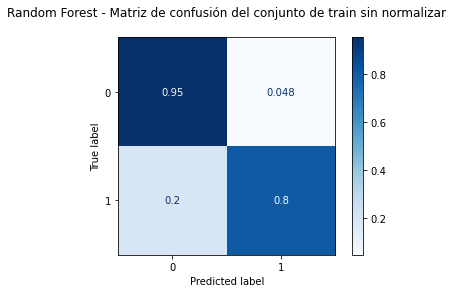

In [210]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

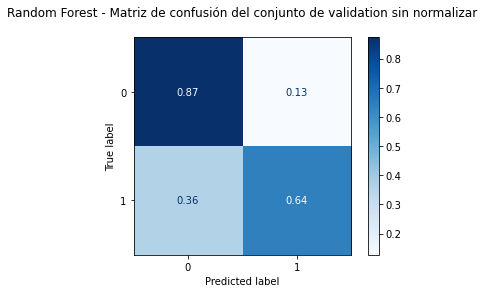

In [211]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## RandomForestClassifier - Grid Search

In [212]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = RandomForestClassifier(random_state= 0)

In [213]:
param_grid = {'cla__n_estimators' : [75, 100],
                'cla__criterion':['gini', 'entropy'],
                'cla__max_depth': [20, 25],
                'cla__min_samples_split': [20, 25],
                'cla__min_samples_leaf':[5, 6, 8],
                'cla__max_features':[0.5, 0.7, 0.8]}

In [214]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [215]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [216]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
rfc_cv = model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [217]:
model.best_params_

{'cla__n_estimators': 100,
 'cla__min_samples_split': 20,
 'cla__min_samples_leaf': 8,
 'cla__max_features': 0.7,
 'cla__max_depth': 25,
 'cla__criterion': 'entropy'}

In [218]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [219]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4764
           1       0.87      0.78      0.82      2132

    accuracy                           0.90      6896
   macro avg       0.89      0.87      0.88      6896
weighted avg       0.90      0.90      0.90      6896



In [220]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2015
           1       0.70      0.64      0.67       941

    accuracy                           0.80      2956
   macro avg       0.77      0.76      0.76      2956
weighted avg       0.80      0.80      0.80      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

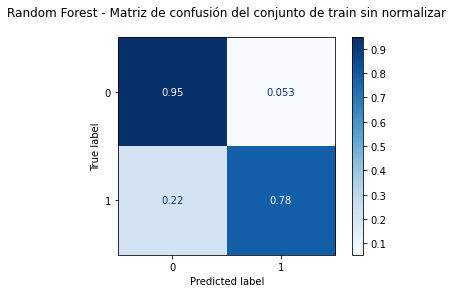

In [221]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

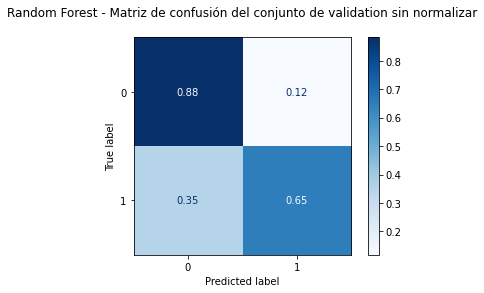

In [222]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Default

In [223]:
# Preproceso 1 para XGBClassifier - Default
scaler = MaxAbsScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0)

In [225]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [226]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [227]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
xgbc = model

[16:01:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [228]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [229]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4764
           1       0.86      0.73      0.79      2132

    accuracy                           0.88      6896
   macro avg       0.87      0.84      0.85      6896
weighted avg       0.88      0.88      0.88      6896



In [230]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2015
           1       0.62      0.51      0.56       941

    accuracy                           0.75      2956
   macro avg       0.71      0.68      0.69      2956
weighted avg       0.74      0.75      0.74      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

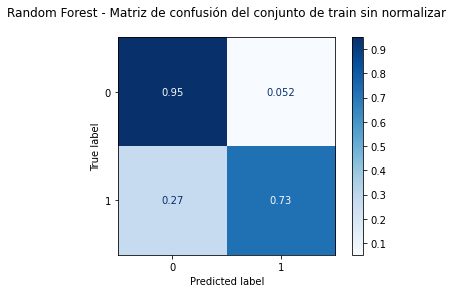

In [231]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

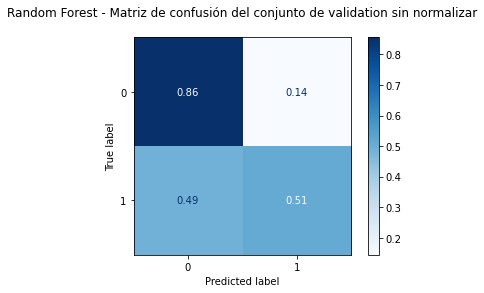

In [232]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Grid Search

In [247]:
# Preproceso 1 para SGDRegressor - Default
scaler = MaxAbsScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0, use_label_encoder=False)

In [248]:
param_grid = {
    'cla__alpha' : [0.01, 0.42, 0.30],
    'cla__max_depth': [8, 16, 32],
    'cla__n_estimators': [5, 10, 15],
    'cla__booster':['gbtree', 'dart'],
    'cla__eval_metric': ['mlogloss']
}

In [249]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [250]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [251]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
xgbc_cv = model

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [252]:
model.best_params_

{'cla__alpha': 0.42,
 'cla__booster': 'gbtree',
 'cla__eval_metric': 'mlogloss',
 'cla__max_depth': 8,
 'cla__n_estimators': 15}

In [253]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [254]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4764
           1       0.81      0.75      0.78      2132

    accuracy                           0.87      6896
   macro avg       0.85      0.83      0.84      6896
weighted avg       0.87      0.87      0.87      6896



In [255]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2015
           1       0.62      0.51      0.56       941

    accuracy                           0.75      2956
   macro avg       0.71      0.68      0.69      2956
weighted avg       0.74      0.75      0.74      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train\n')

<Figure size 432x288 with 0 Axes>

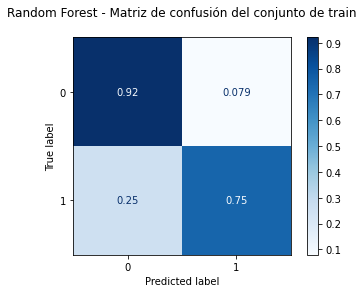

In [246]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validación\n')

<Figure size 432x288 with 0 Axes>

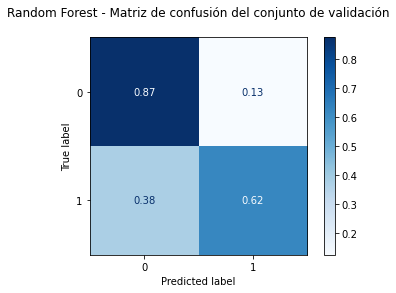

In [245]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validación\n')

FIN
----
----